In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### defining the function

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

f(3.0)

20.0

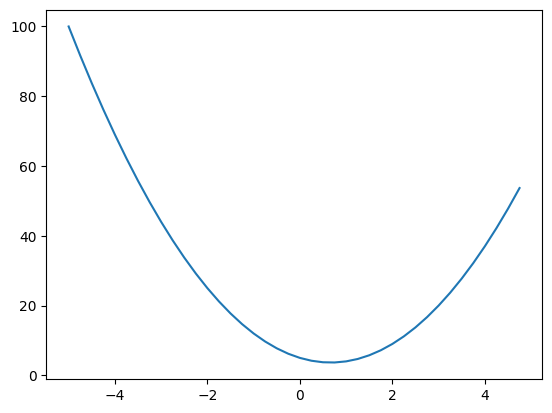

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

### finding it's gradient manually

In [4]:
h = 0.000001
x = 2/3
dy_dx = (f(x + h) - f(x))/h
dy_dx

2.999378523327323e-06

In [5]:
# more complex one

# function definition
def f(a, b, c):
  return a*b + c

a = 2.0
b = -3.0
c = 10.0
y = f(a, b, c)
print(y)

4.0


In [6]:
# finding dy/dc
h = 0.0001
dy_dc = (f(a, b, c + h) - f(a, b, c))/h
print(dy_dc)

0.9999999999976694


### defining the class for making graphs to compute gradients 

In [7]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    """it returns a new Value object that is the tanh of the original Value object, and it also sets up the backward function for the tanh operation in it's object"""
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # tanh function is (e^(2x) - 1)/(e^(2x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad # the derivative of tanh is 1 - tanh^2, and we multiply by out.grad to chain the gradients together i.e dy/dx = dy/dt * dt/dx, where dy/dt is out.grad and dt/dx is 1 - t^2
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [8]:
# using the Value class, graph to compute gradients
x = Value(5)
y = x * x

y.backward()
x.grad

10.0

### defining functions to draw the computational graph visually

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


Value(data=-8.0)
graph with gradients


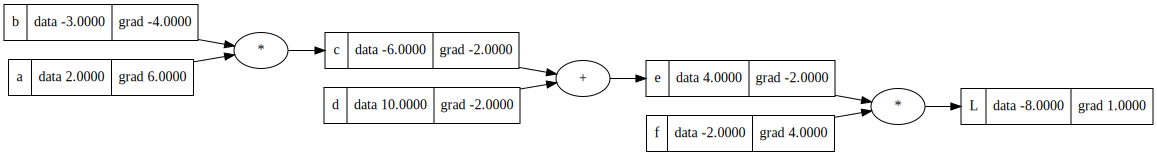

In [10]:
# let's build a computational graph and visualize it
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a*b; c.label = 'c'

d = Value(10.0, label='d')
e = c + d; e.label = 'e'

f = Value(-2.0, label='f')
L = e * f; L.label = 'L' # L is the loss function , in other words L = (a*b + d) * f

print(L)
L.backward()
print("graph with gradients")
draw_dot(L)

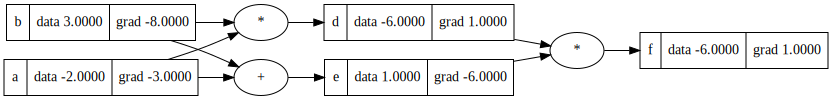

In [11]:
# when same variable is used multiple times in the graph, we need to make sure that the gradients are accumulated correctly, not overwritten, and this is what happens in the backward function of the Value class, where we add to the existing gradient instead of overwriting it.
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()
draw_dot(f)

### Training: update the data points (weights) using gradient descent to minimize the function output {consider it as a loss function}

In [12]:
# loss function optimization using gradient descent
# as the function mentioned is linear, the gradient takes it to the negative infinity
for i in range(10):
    L = (a*b + d) * f
    print(f"value of L at iteration {i}: {L.data}")
    
    L.backward()
    a.data -= 0.01 * a.grad
    b.data -= 0.01 * b.grad
    d.data -= 0.01 * d.grad
    f.data -= 0.01 * f.grad
    
    # zero the gradients after each step
    a.grad = 0.0
    b.grad = 0.0
    d.grad = 0.0
    f.grad = 0.0
    

value of L at iteration 0: 72.0
value of L at iteration 1: 57.347395999999996
value of L at iteration 2: 39.964105073941845
value of L at iteration 3: -5.604703517987295
value of L at iteration 4: -85.39876248178857
value of L at iteration 5: -117.00209583837461
value of L at iteration 6: -69.54104087100933
value of L at iteration 7: -20.97696950676468
value of L at iteration 8: 11.269619769166667
value of L at iteration 9: 28.314525881920982


In [13]:
# more complex example
# searching the value of x to minimize y
x = Value(2.0, label='x')
y = x * x; y.label = 'y'
print(f"initial value of y: {y.data}")

for i in range(10):
    y = x * x
    print(f"value of y at iteration {i}: {y.data}")
    
    y.backward()
    x.data -= 0.1 * x.grad
    
    # zero the gradient after each step
    x.grad = 0.0

initial value of y: 4.0
value of y at iteration 0: 4.0
value of y at iteration 1: 2.5600000000000005
value of y at iteration 2: 1.6384
value of y at iteration 3: 1.048576
value of y at iteration 4: 0.67108864
value of y at iteration 5: 0.42949672960000007
value of y at iteration 6: 0.2748779069440001
value of y at iteration 7: 0.17592186044416008
value of y at iteration 8: 0.11258999068426244
value of y at iteration 9: 0.07205759403792797


### more about gradients and functions (tanh)

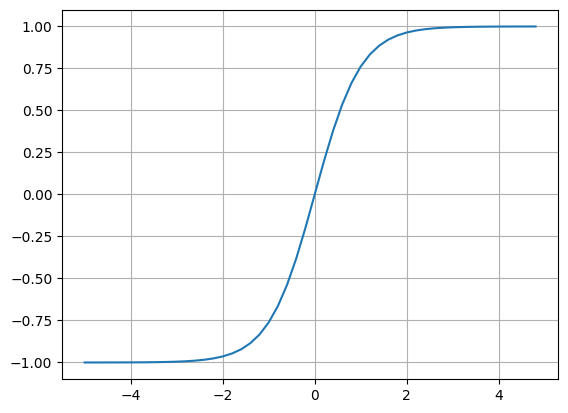

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

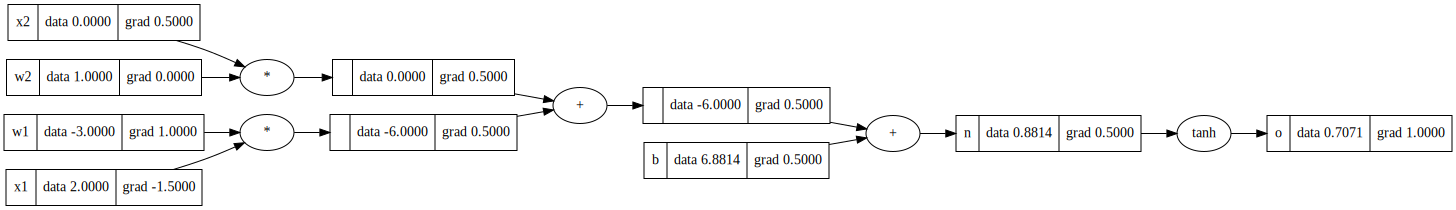

In [15]:
# calculating the gradients (backword) through the tanh function

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

n = x1*w1 + x2*w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

# o = tanh(n)
# do/dn = 1 - o**2
# 1 - o.data**2 -> 0.4999999999999999

### pytorch example

In [16]:
# using .backward() to compute gradients using pytorch
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
print('---')
o.backward()
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
